In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt

from ViTGSOM import AutoEncoder, ViTSOMLoss
from help_functions import get_grid_coords, decay_exponential, calculate_purity, plot_umap_som_weights, get_node_labels

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [13]:
config = {
    'img_size': 28,
    'patch_size': 4,
    'num_of_channels': 1,
    'embed_dim': 16,
    'enc_depth': 4,
    'dec_depth': 2,
    'num_heads': 2,
    'mlp_dim': 64,
    'epochs': 500,
    'lr': 0.0005,
    'grow_after_epochs': 10,
    'grow_threshold': 0.5,
    'spread_factor': 0.01,
    'som_rows': 5,
    'som_cols': 5,
    'fine_tuning_epochs': 200
}

In [14]:
autoencoder = AutoEncoder(img_size=config['img_size'], 
                          patch_size=config['patch_size'], 
                          num_of_channels=config['num_of_channels'], 
                          embed_dim=config['embed_dim'], 
                          enc_depth=config['enc_depth'],                                      
                          dec_depth=config['dec_depth'], 
                          num_heads=config['num_heads'], 
                          mlp_dim=config['mlp_dim'],
                          spread_factor=config['spread_factor'],
                          som_rows=config['som_rows'],
                          som_cols=config['som_cols'])    

In [15]:
optimizer = optim.AdamW(autoencoder.parameters(), lr=config['lr'])
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)
criterion = ViTSOMLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)
autoencoder.train()

# starting and ending value of sigma, beta is calculated to reach sigma_end at last epoch
sigma_start = autoencoder.get_sigma()
sigma_end = 0.5
beta = (sigma_end / sigma_start) ** (1 / config['epochs'])
epochs_since_reset = 0

grid_coords = get_grid_coords(config['som_rows'], config['som_cols'], device)
current_sigma = sigma_start

history = {'total': [], 'mse': [], 'som': [], 'purity': []}

checkpoints = [0,10,25,50,100,150,200,250,300,350,400,450,500]
snapshot_som_weights = {}
snapshot_som_weights[0] = (
    autoencoder.get_som_weights().detach().cpu().numpy(),
    get_node_labels(autoencoder, loader, device)
)

grid_expanding = True
epoch_exit = config['epochs']
print("Start training")
for epoch in range(config['epochs']):
    if not grid_expanding and epoch > epoch_exit:
        break
    
    running_loss = 0.0
    running_mse = 0.0
    running_som = 0.0
    current_lambda = 1 
    
    sigma_t = decay_exponential(sigma_start, beta, epochs_since_reset)
    
    for images, _ in loader:
        images = images.to(device)
        
        reconstructed, latent = autoencoder(images)
        som_weights = autoencoder.get_som_weights()
        
        total_loss, l_nn, l_som = criterion(images, reconstructed, latent, som_weights, grid_coords, sigma_t, current_lambda)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        running_mse += l_nn.item()
        running_som += l_som.item()
    
    # updating learning rule through CosineAnnealingLR
    scheduler.step()
    
    if epoch+1 in checkpoints:        
        weights_np = autoencoder.get_som_weights().detach().cpu().numpy()
        labels_np = get_node_labels(autoencoder, loader, device)
        snapshot_som_weights[epoch+1] = (weights_np, labels_np)
        
    if grid_expanding and epoch % config['grow_after_epochs'] == 0:
        epochs_since_reset += 1
        if autoencoder.check_growth(loader, device):
            optimizer = optim.AdamW(autoencoder.parameters(), lr=config['lr'])

            for param_group in optimizer.param_groups: param_group['initial_lr'] = config['lr']
            
            scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'], last_epoch=epoch)
            grid_coords = get_grid_coords(autoencoder.current_row_num, autoencoder.current_col_num, device)

            sigma_start = autoencoder.get_sigma()
            sigma_start = min(sigma_start, 2.0)
            beta = (sigma_end / sigma_start) ** (1 / max(1, config['grow_after_epochs']))
            epochs_since_reset = 0
        else:
            grid_expanding = False
            epoch_exit = epoch + config['fine_tuning_epochs']
            
            optimizer = optim.AdamW(autoencoder.parameters(), lr=config['lr'])

            for param_group in optimizer.param_groups: param_group['initial_lr'] = config['lr']
            
            scheduler = CosineAnnealingLR(optimizer, T_max=config['fine_tuning_epochs'])
            
            sigma_start = min(autoencoder.get_sigma(), 2.0)
            sigma_end = 0.5
            beta = (sigma_end / sigma_start) ** (1 / config['fine_tuning_epochs'])
            epochs_since_reset = 0
            print(f"Grid not expanding, training ends at epoch {epoch_exit}")
    else:
        epochs_since_reset += 1
    
    
    purity = calculate_purity(autoencoder, loader, device)
    
    avg_total = running_loss / len(loader)
    avg_mse = running_mse / len(loader)
    avg_som = running_som / len(loader)
    
    history['total'].append(avg_total)
    history['mse'].append(avg_mse)
    history['som'].append(avg_som)
    history['purity'].append(purity)
    
    print(f"Epoch {epoch+1}/{config['epochs']} | Sigma: {sigma_t:.3f} | Loss: {avg_total:.8f} (MSE: {avg_mse:.8f} | SOM: {avg_som:.8f}) | Purity: {purity:.5f}")


Start training
Latent variance (mqe0): 0.0005678690504282713
Spread Factor: 0.01
Threshold, mqe0 * spread_factor: 5.678690504282713e-06
MQE 0.19467101005613804 > Threshold 5.678690504282713e-06. Growing
Current grid size: (6, 5)
Epoch 1/500 | Sigma: 3.000 | Loss: 8.95318969 (MSE: 0.05105171 | SOM: 8.90213797) | Purity: 0.11237
Epoch 2/500 | Sigma: 2.000 | Loss: 1.15076718 (MSE: 0.02126702 | SOM: 1.12950015) | Purity: 0.11237
Epoch 3/500 | Sigma: 1.741 | Loss: 0.10889793 (MSE: 0.01526538 | SOM: 0.09363255) | Purity: 0.11855
Epoch 4/500 | Sigma: 1.516 | Loss: 0.02168766 (MSE: 0.01324334 | SOM: 0.00844432) | Purity: 0.35938
Epoch 5/500 | Sigma: 1.320 | Loss: 0.01165931 (MSE: 0.01008443 | SOM: 0.00157488) | Purity: 0.54178
Epoch 6/500 | Sigma: 1.149 | Loss: 0.00977649 (MSE: 0.00884956 | SOM: 0.00092693) | Purity: 0.60458
Epoch 7/500 | Sigma: 1.000 | Loss: 0.00865691 (MSE: 0.00785552 | SOM: 0.00080139) | Purity: 0.61510
Epoch 8/500 | Sigma: 0.871 | Loss: 0.00758848 (MSE: 0.00689934 | SOM: 0

KeyboardInterrupt: 

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


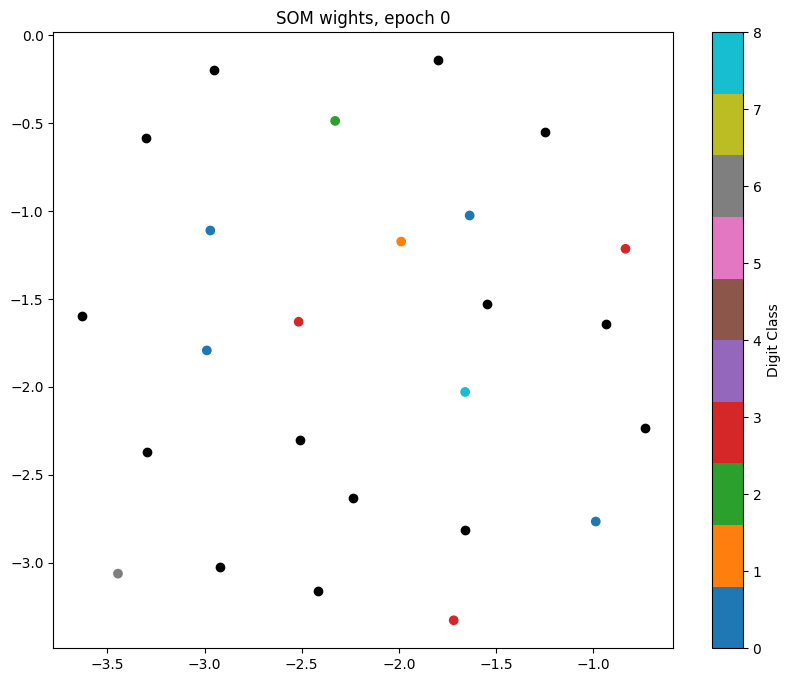

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


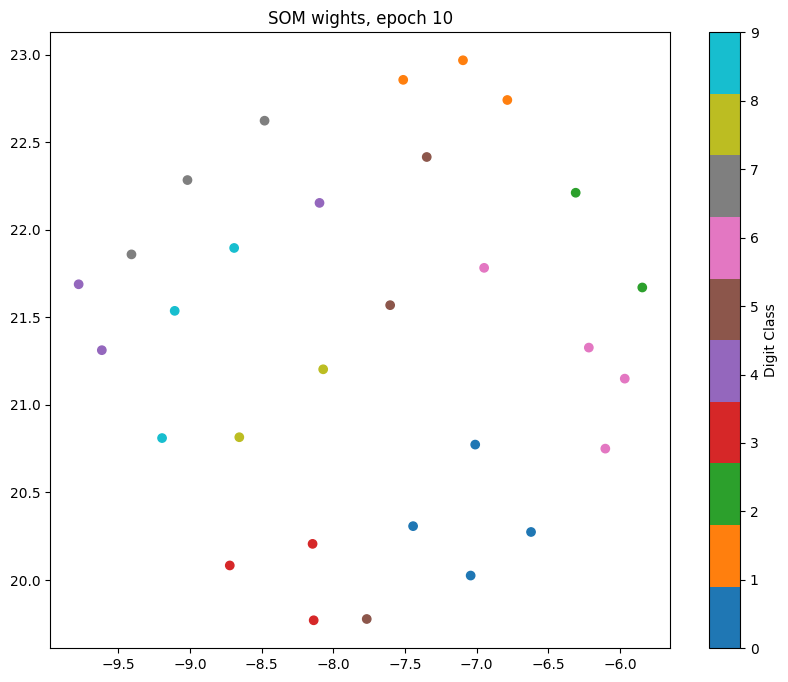

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


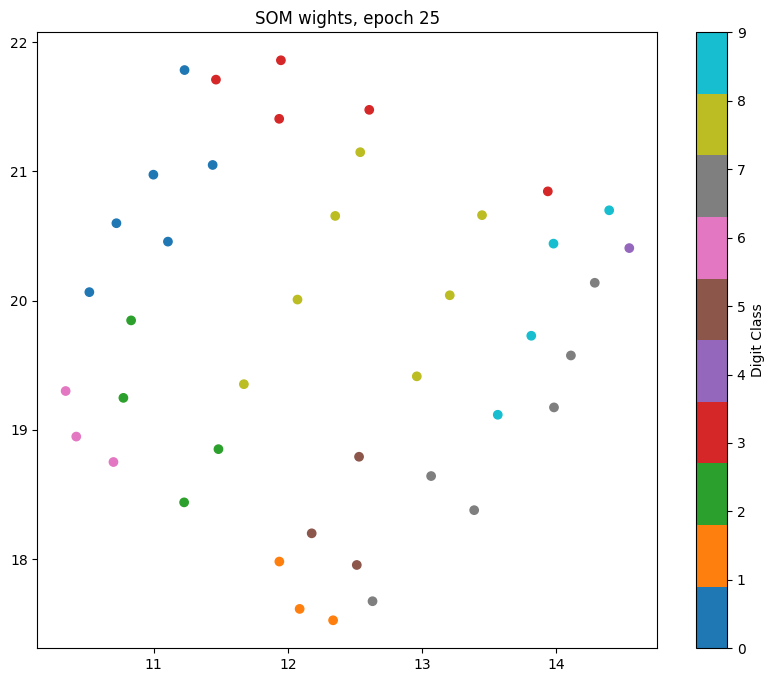

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


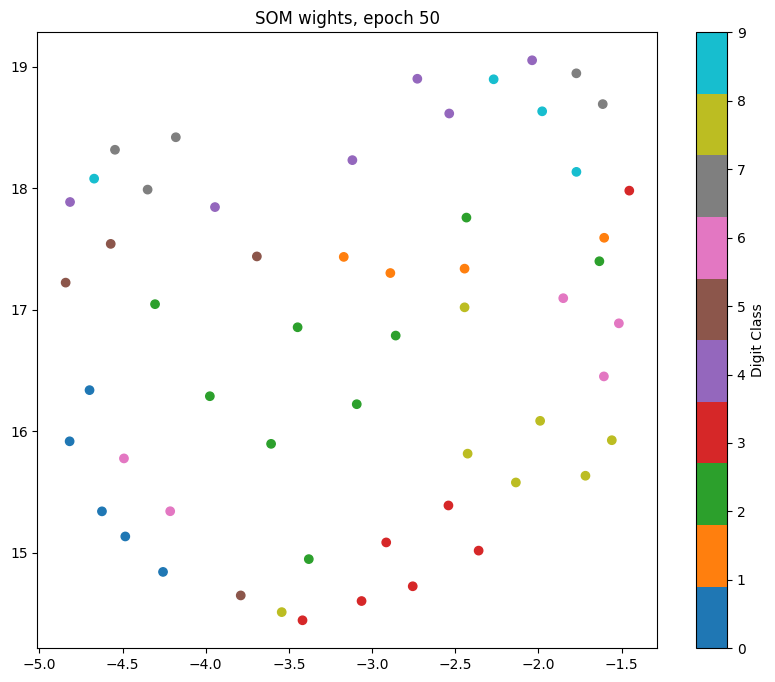

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


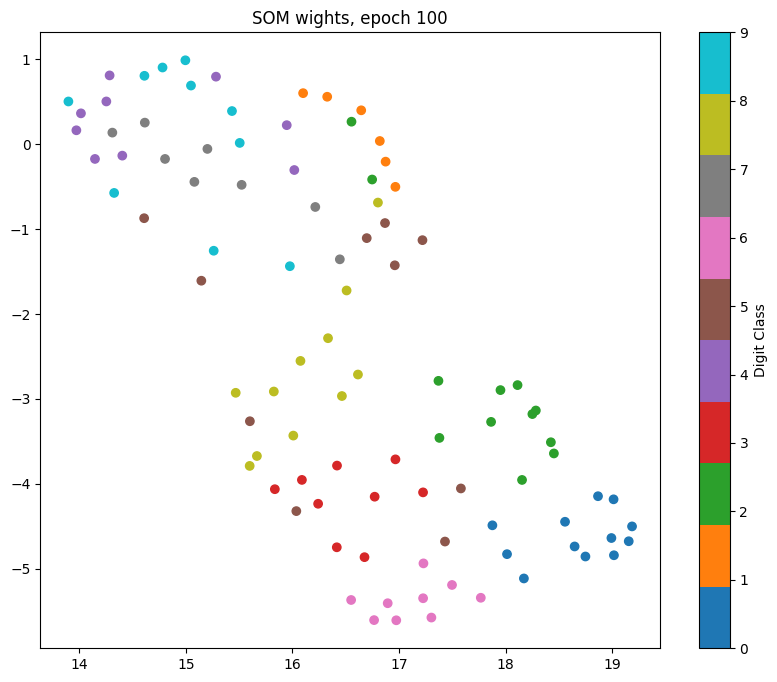

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


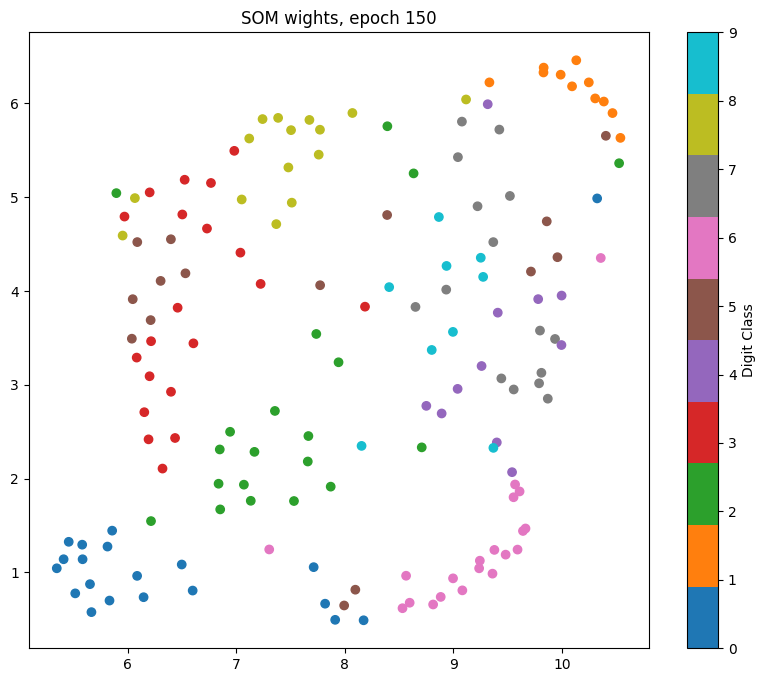

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


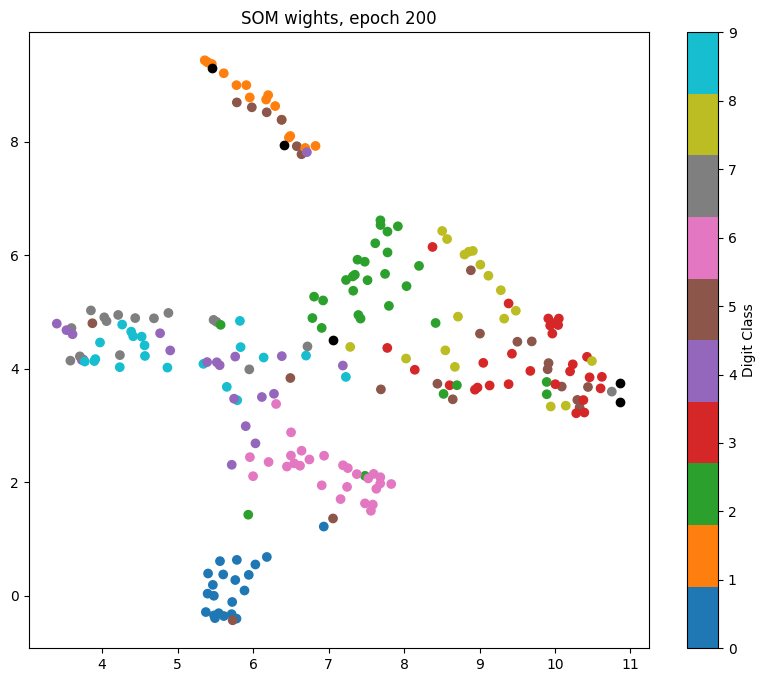

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


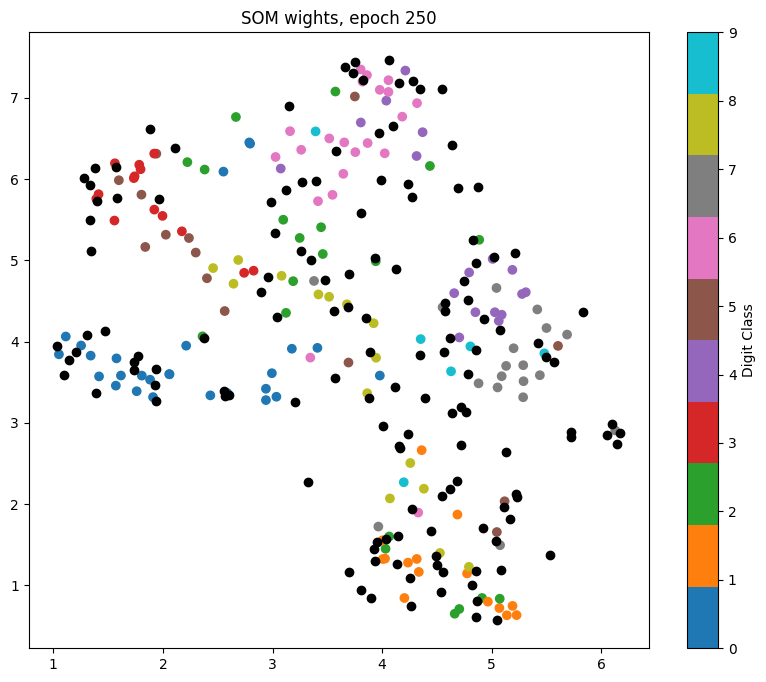

In [16]:
plot_umap_som_weights(snapshot_som_weights)